## MLP regresija

KIEKIS               0
PIRM_REG_METAI_LT    0
PIRM_REG_MEN_LT      0
dtype: int64


c:\Users\dakse\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1113: RuntimeWarning: overflow encountered in square
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
c:\Users\dakse\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Geriausi parametrai: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'solver': 'adam'}


c:\Users\dakse\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\dakse\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\dakse\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\dakse\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the 

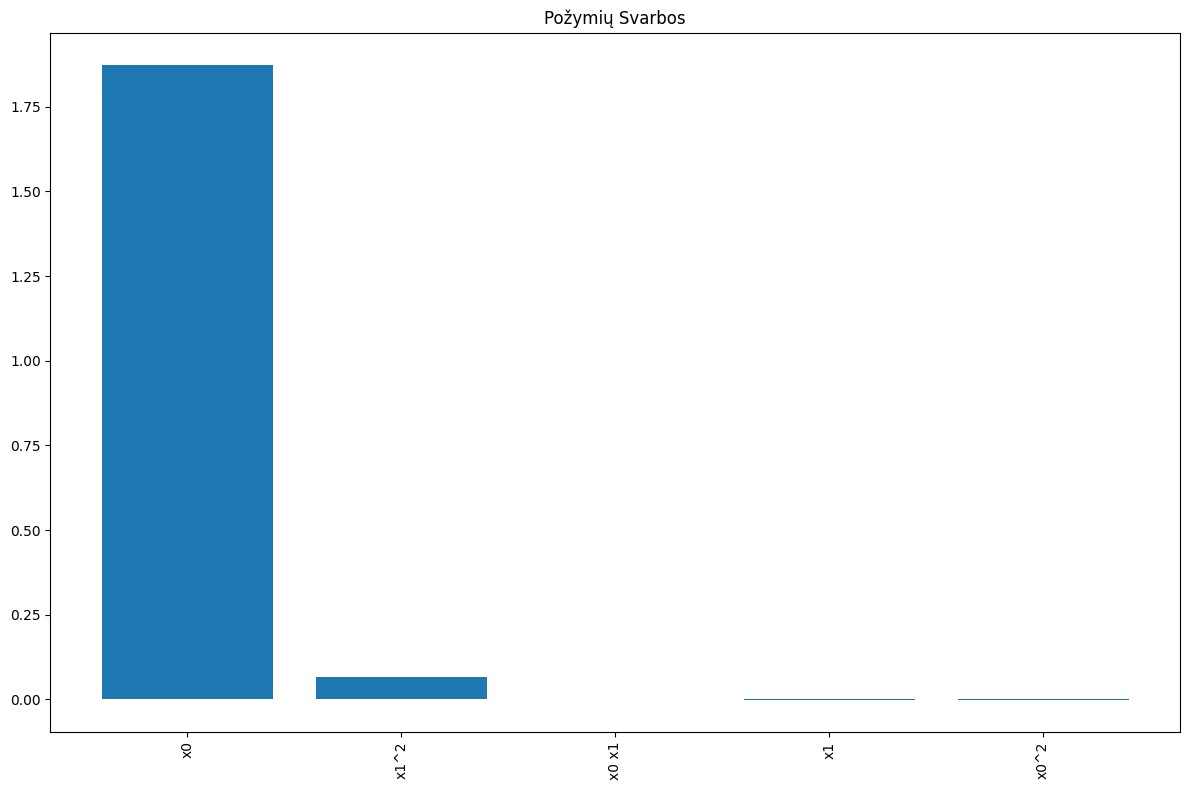

Treniravimo MSE: 1979735.6131843212
Testavimo MSE: 2367670.5406106575
Treniravimo R2: 0.9285565591331908
Testavimo R2: 0.9114976436601656
Kryžminės validacijos (cv=5) R2 reikšmės: [0.76393499 0.70418565 0.71400874 0.78341462 0.77572369]
Kryžminės validacijos (cv=5) vidutinis R2: 0.7482535379224486
Kryžminės validacijos (cv=10) R2 reikšmės: [0.84106343 0.77349042 0.6978796  0.67445964 0.83468961 0.90102985
 0.85018442 0.88498988 0.80288096 0.88990076]
Kryžminės validacijos (cv=10) vidutinis R2: 0.815056856147101


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np

# Įkeliame duomenis iš pateikto failo
data = pd.read_csv("data_visi_v2.csv")
print(data.isnull().sum())

# Užpildome trūkstamas reikšmes vidurkiu
data.fillna(data.mean(), inplace=True)

# Pasiruošiame duomenis (be 'mpg' stulpelio)
X = data.drop(columns=['KIEKIS'])
y = data['KIEKIS']

# Padalijame į treniravimo ir testavimo rinkinius
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizuojame duomenis
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Sukuriame polinominius požymius
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Sukuriame MLP regresorių su hiperparametrų paieška
param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 50), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

mlp_regressor = MLPRegressor(max_iter=1000, random_state=42)

grid_search = GridSearchCV(estimator=mlp_regressor, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_poly, y_train)

# Geriausi parametrai
best_params = grid_search.best_params_
print(f'Geriausi parametrai: {best_params}')

# Geriausias modelis
best_model = grid_search.best_estimator_

# Atliekame prognozes su geriausiu modeliu
y_train_pred = best_model.predict(X_train_poly)
y_test_pred = best_model.predict(X_test_poly)

# Vertiname modelį
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Kryžminė validacija su pilnu duomenų rinkiniu
cv_scores_5 = cross_val_score(best_model, X_train_poly, y_train, cv=5, scoring='r2')
cv_scores_10 = cross_val_score(best_model, X_train_poly, y_train, cv=10, scoring='r2')

# Požymių svarbos vertinimas
result = permutation_importance(best_model, X_test_poly, y_test, n_repeats=10, random_state=42)
importance = result.importances_mean

# Požymių svarbos vizualizacija
features = poly.get_feature_names_out()
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Požymių Svarbos")
plt.bar(range(X_test_poly.shape[1]), importance[indices], align="center")
plt.xticks(range(X_test_poly.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()

# Rezultatų spausdinimas
print(f'Treniravimo MSE: {train_mse}')
print(f'Testavimo MSE: {test_mse}')
print(f'Treniravimo R2: {train_r2}')
print(f'Testavimo R2: {test_r2}')

print(f'Kryžminės validacijos (cv=5) R2 reikšmės: {cv_scores_5}')
print(f'Kryžminės validacijos (cv=5) vidutinis R2: {cv_scores_5.mean()}')

print(f'Kryžminės validacijos (cv=10) R2 reikšmės: {cv_scores_10}')
print(f'Kryžminės validacijos (cv=10) vidutinis R2: {cv_scores_10.mean()}')


In [ ]:
# Po ........ 36 min 
# Treniravimo MSE: 1979735.6131843212
# Testavimo MSE: 2367670.5406106575
# Treniravimo R2: 0.9285565591331908
# Testavimo R2: 0.9114976436601656
# Kryžminės validacijos (cv=5) R2 reikšmės: [0.76393499 0.70418565 0.71400874 0.78341462 0.77572369]
# Kryžminės validacijos (cv=5) vidutinis R2: 0.7482535379224486
# Kryžminės validacijos (cv=10) R2 reikšmės: [0.84106343 0.77349042 0.6978796  0.67445964 0.83468961 0.90102985
#  0.85018442 0.88498988 0.80288096 0.88990076]
# Kryžminės validacijos (cv=10) vidutinis R2: 0.815056856147101